# Problem Statement

## Use Random Forest to prepare a model on fraud data 
## treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set_style('darkgrid')
from collections import Counter
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Dataset
df = pd.read_csv('Fraud_Check.csv')
df

Undergrad Marital.Status  Taxable.Income  City.Population  \
0          NO         Single           68833            50047   
1         YES       Divorced           33700           134075   
2          NO        Married           36925           160205   
3         YES         Single           50190           193264   
4          NO        Married           81002            27533   
..        ...            ...             ...              ...   
595       YES       Divorced           76340            39492   
596       YES       Divorced           69967            55369   
597        NO       Divorced           47334           154058   
598       YES        Married           98592           180083   
599        NO       Divorced           96519           158137   

     Work.Experience Urban  
0                 10   YES  
1                 18   YES  
2                 30   YES  
3                 15   YES  
4                 28    NO  
..               ...   ...  
595                7   YES  
596                2   YES  
597                0   YES  
598               17    NO  
599               16    NO  

[600 rows x 6 columns]

## Data Exploration 

In [3]:
df.isnull().any()

Undergrad          False
Marital.Status     False
Taxable.Income     False
City.Population    False
Work.Experience    False
Urban              False
dtype: bool

In [4]:
df.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

 We have no missing data so all the entries are valid for use.


###  Descriptive Analysis

In [5]:
df.shape

(600, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [7]:
df[df.duplicated()].shape

(0, 6)

In [8]:
df[df.duplicated()]

Empty DataFrame
Columns: [Undergrad, Marital.Status, Taxable.Income, City.Population, Work.Experience, Urban]
Index: []

### there are no duplicated values present in dataset

In [9]:
df.describe()

Taxable.Income  City.Population  Work.Experience
count      600.000000       600.000000       600.000000
mean     55208.375000    108747.368333        15.558333
std      26204.827597     49850.075134         8.842147
min      10003.000000     25779.000000         0.000000
25%      32871.500000     66966.750000         8.000000
50%      55074.500000    106493.500000        15.000000
75%      78611.750000    150114.250000        24.000000
max      99619.000000    199778.000000        30.000000

The features are not on the same scale. For example `City.Population` has a mean of `108747.36` while `Work.Experience` has a mean value of `15.55`. Features should be on the same scale for algorithms such as logistic regression (gradient descent) to converge smoothly. Let's go ahead and check further.

### Feature Engineering

### Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”

In [10]:
df['Taxable.Income'].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Taxable.Income, dtype: float64

In [11]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
df1=df.copy()
df1['taxable_category'] = pd.cut(x = df1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
df1.head()

Undergrad Marital.Status  Taxable.Income  City.Population  Work.Experience  \
0        NO         Single           68833            50047               10   
1       YES       Divorced           33700           134075               18   
2        NO        Married           36925           160205               30   
3       YES         Single           50190           193264               15   
4        NO        Married           81002            27533               28   

  Urban taxable_category  
0   YES             Good  
1   YES             Good  
2   YES             Good  
3   YES             Good  
4    NO             Good

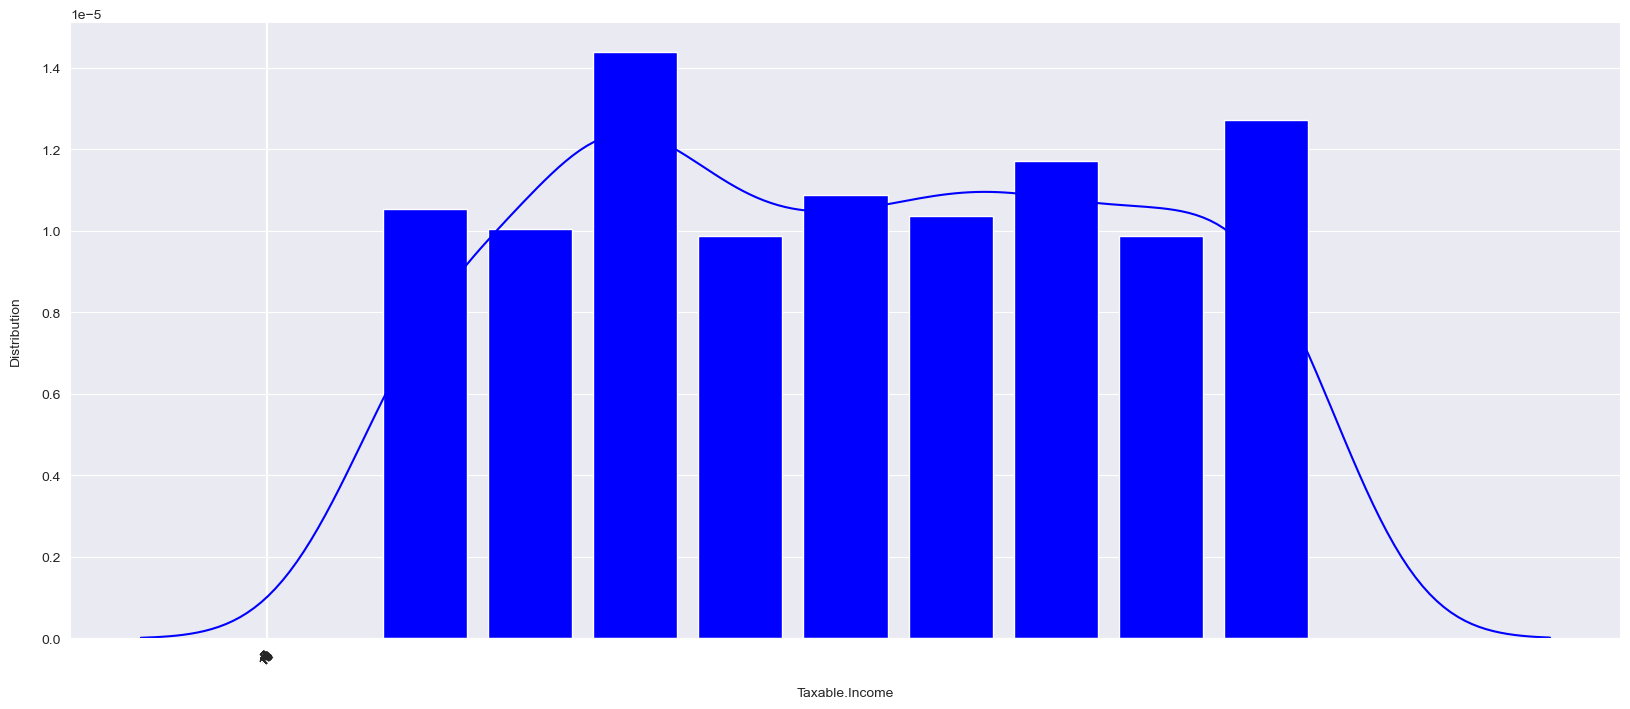

In [12]:
def distplot(param):
    plt.figure(figsize=(20,8))
    sns.distplot(df[param], color = "blue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xticks(np.arange(0,20,1),rotation=45)
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Taxable.Income")

In [13]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Undergrad         600 non-null    object  
 1   Marital.Status    600 non-null    object  
 2   Taxable.Income    600 non-null    int64   
 3   City.Population   600 non-null    int64   
 4   Work.Experience   600 non-null    int64   
 5   Urban             600 non-null    object  
 6   taxable_category  600 non-null    category
dtypes: category(1), int64(3), object(3)
memory usage: 29.0+ KB


In [15]:
categorical_features = df1.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban', 'taxable_category'], dtype='object')

In [16]:
numerical_features = df1.describe(include=["int64","float64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

## Data Visualization

 ###  Univariate plots

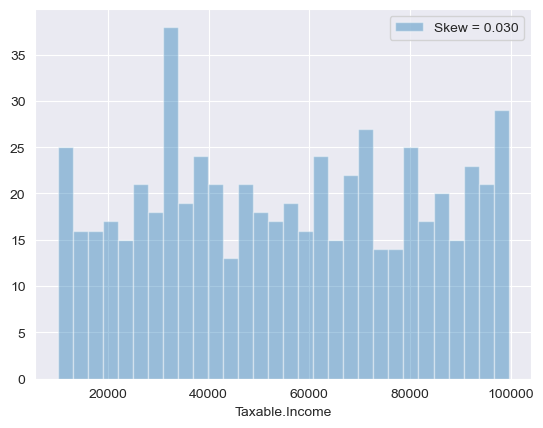

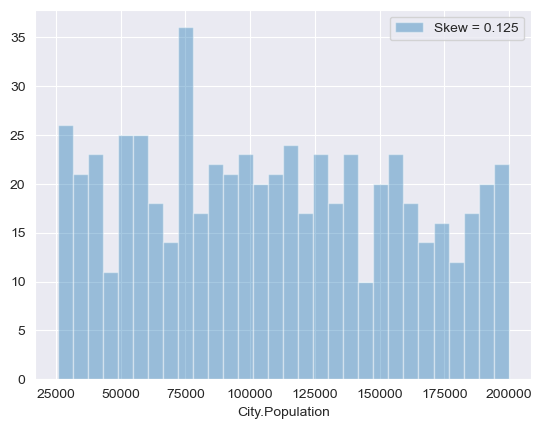

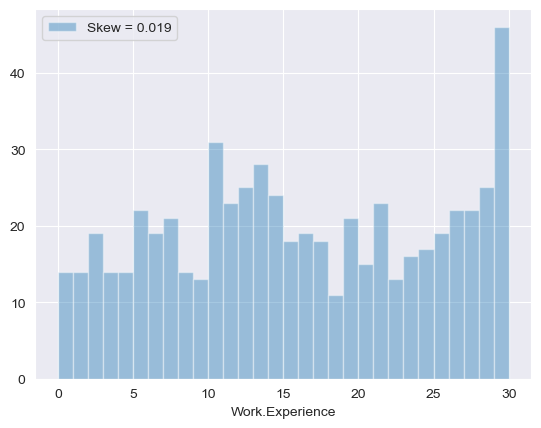

In [17]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

### None of the features is normally distributed.

In [18]:
numerical_features

['Taxable.Income', 'City.Population', 'Work.Experience']

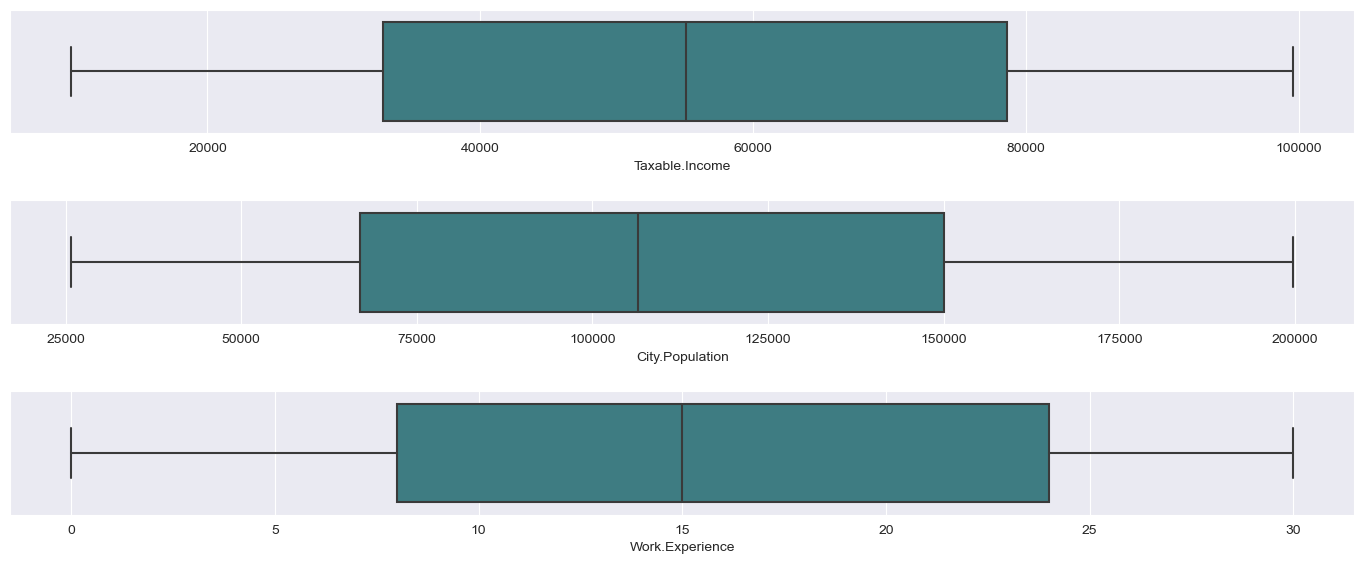

In [19]:
ot=df.copy() 
fig, axes=plt.subplots(3,1,figsize=(14,6),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data=ot,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

<Axes: >

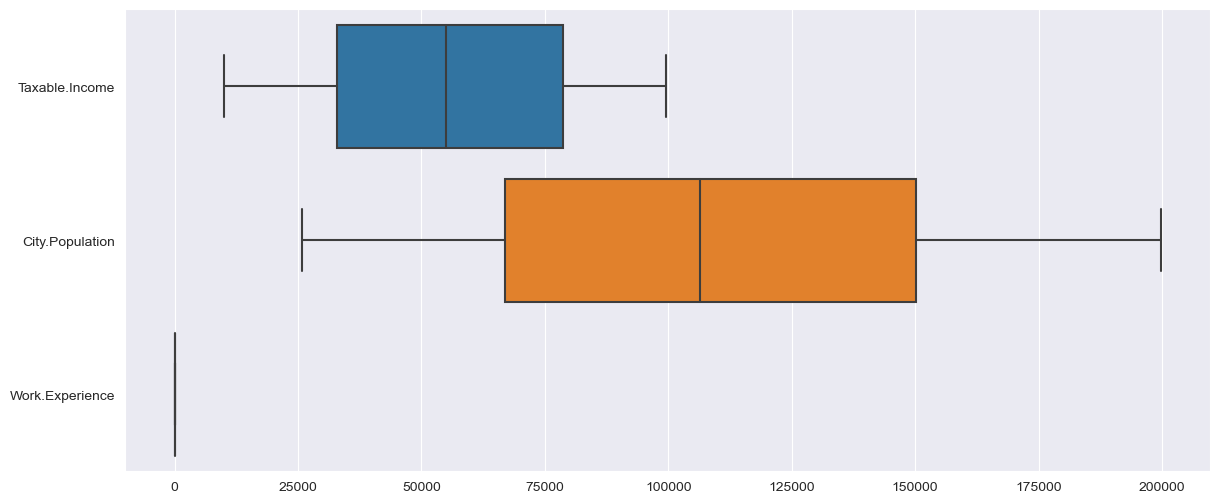

In [20]:
#outlier
plt.figure(figsize=(14,6))
sns.boxplot(data=df[numerical_features], orient="h")

#### Unsurprisingly, **`Work.Experience`** has a mean that is much inferior to the other constituents as we already saw in the previous section.

 ### Multivariate Analysis

<Figure size 800x800 with 0 Axes>

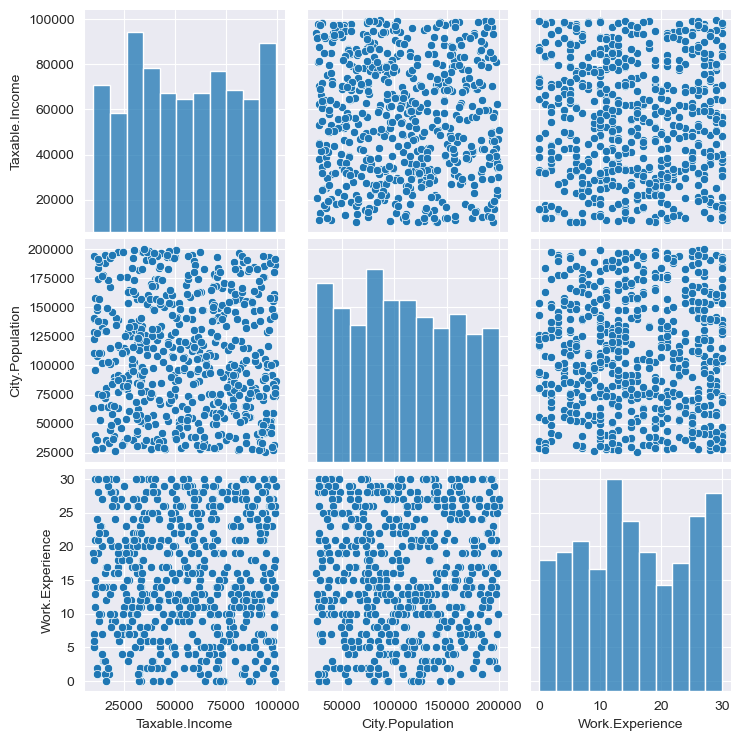

In [21]:
plt.figure(figsize=(8,8))
sns.pairplot(df, palette='coolwarm')
plt.show()

<Axes: >

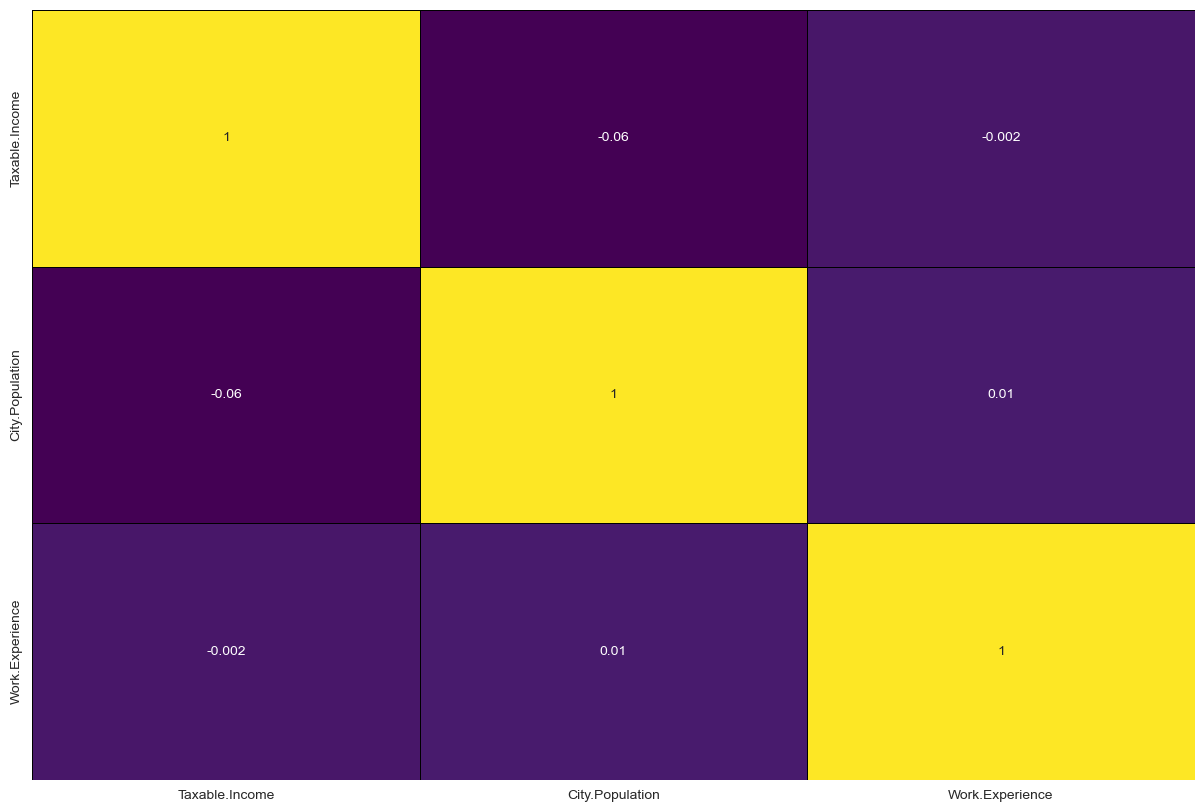

In [22]:
# Having a look at the correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

Index(['Undergrad', 'Marital.Status', 'Urban', 'taxable_category'], dtype='object')


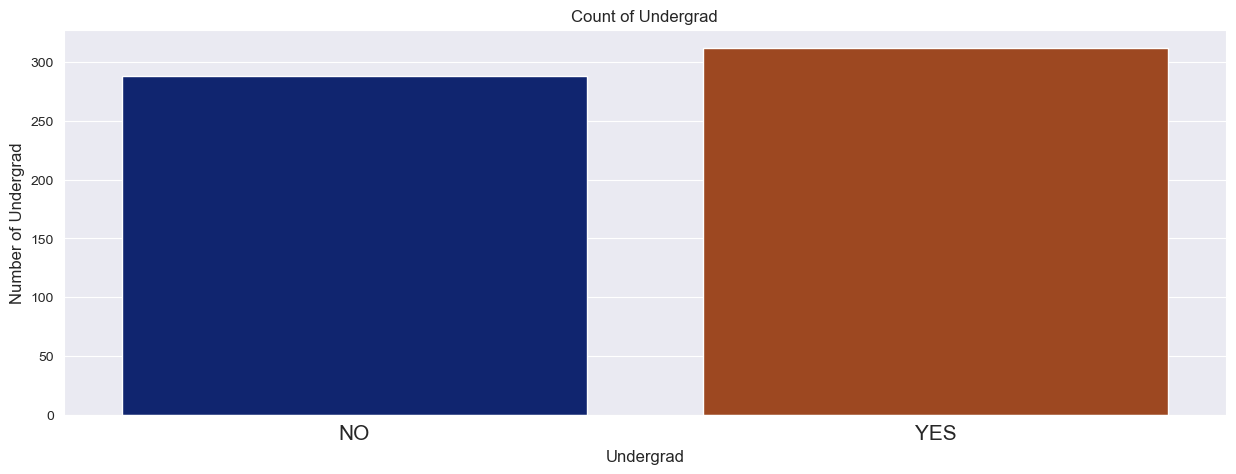

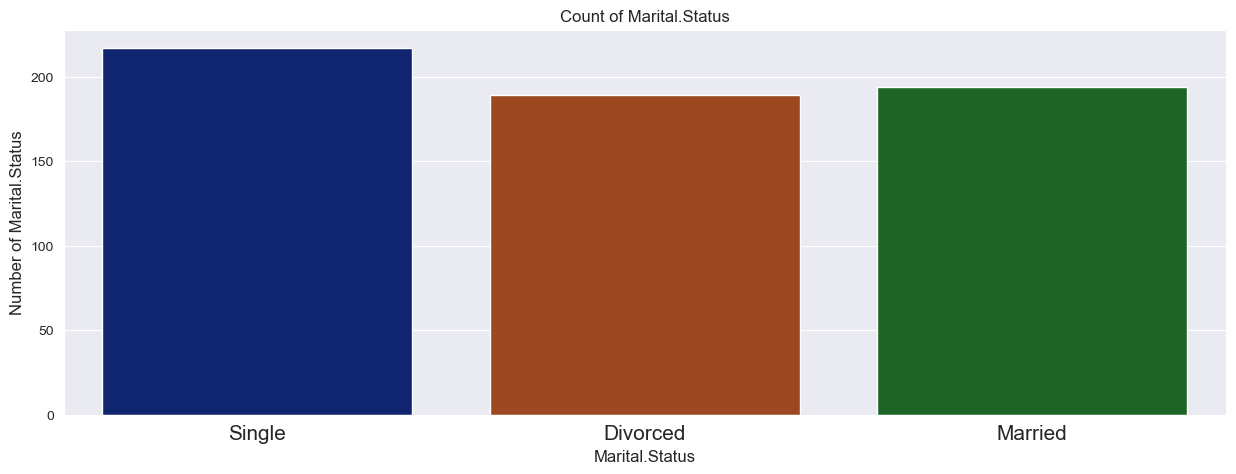

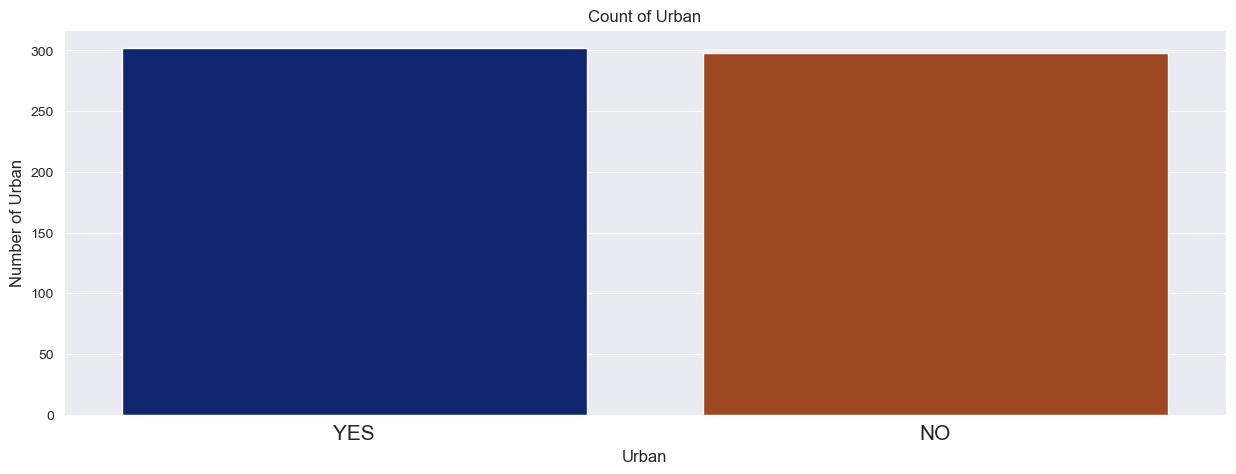

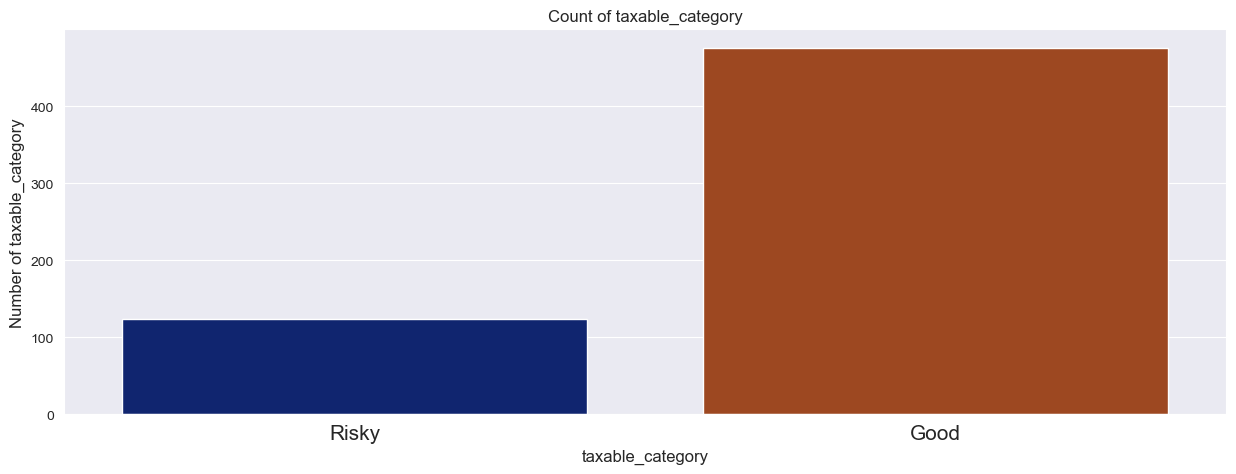

In [23]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(15, 5))
    unique = df1[column].value_counts(ascending=True);
 
    #plt.subplot(1, len(categorical_features), idx+1)    
    plt.title("Count of "+ column)
    sns.countplot(data=df1, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 0, size = 15)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

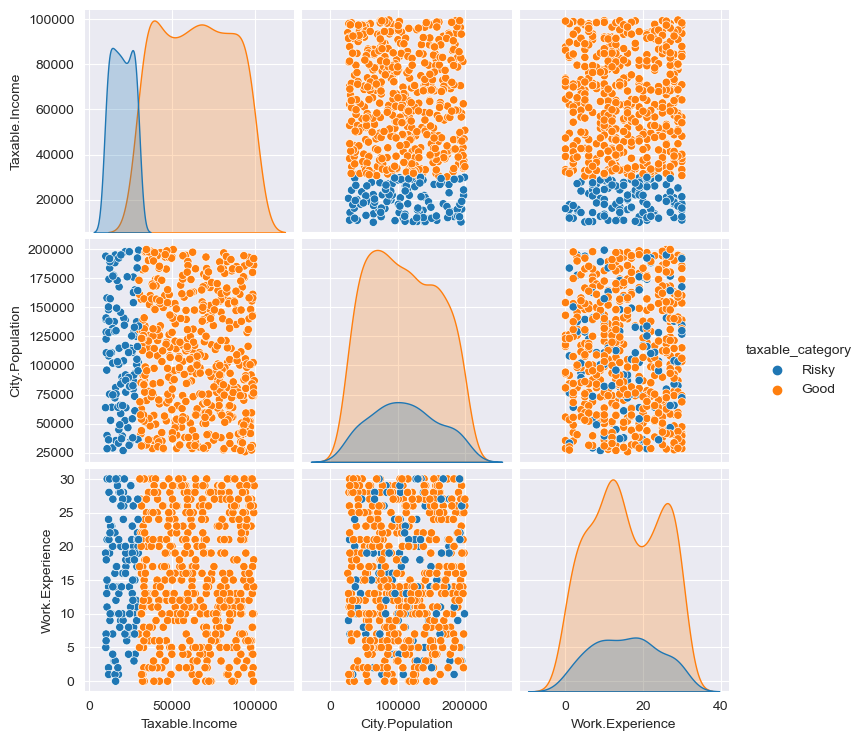

In [24]:
# let's plot pair plot to visualise the attributes all at once
import seaborn as sns
sns.pairplot(data=df1, hue = 'taxable_category')

In [25]:
data_ = df1.copy()
data_.drop('Taxable.Income',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

City.Population  Work.Experience  Undergrad_NO  Undergrad_YES  \
0            50047               10             1              0   
1           134075               18             0              1   
2           160205               30             1              0   
3           193264               15             0              1   
4            27533               28             1              0   

   Marital.Status_Divorced  Marital.Status_Married  Marital.Status_Single  \
0                        0                       0                      1   
1                        1                       0                      0   
2                        0                       1                      0   
3                        0                       0                      1   
4                        0                       1                      0   

   Urban_NO  Urban_YES  
0         0          1  
1         0          1  
2         0          1  
3         0          1  
4         1          0

Text(0.5, 1.0, 'Correlation with Sales \n')

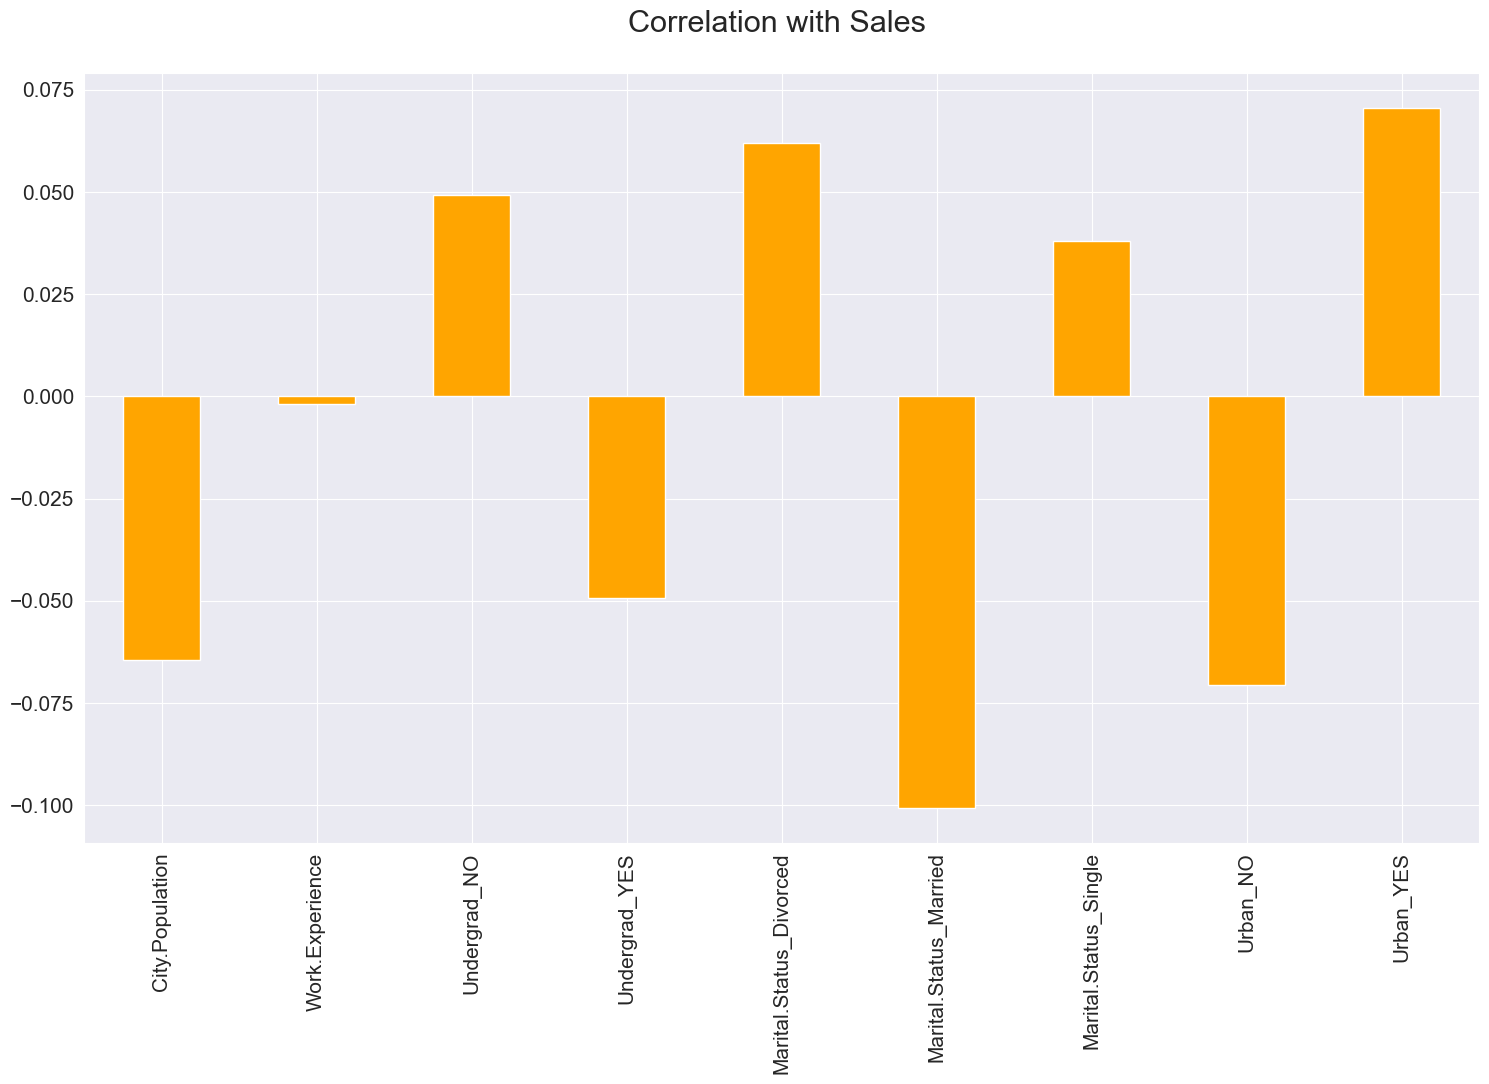

In [26]:
data2 = data_.copy()

correlations = data2.corrwith(df1['Taxable.Income'])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'orange',
        rot = 90, grid = True)
plt.title('Correlation with Sales \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

#### Checking for Imbalanced or balanced dataset with regards to the Target

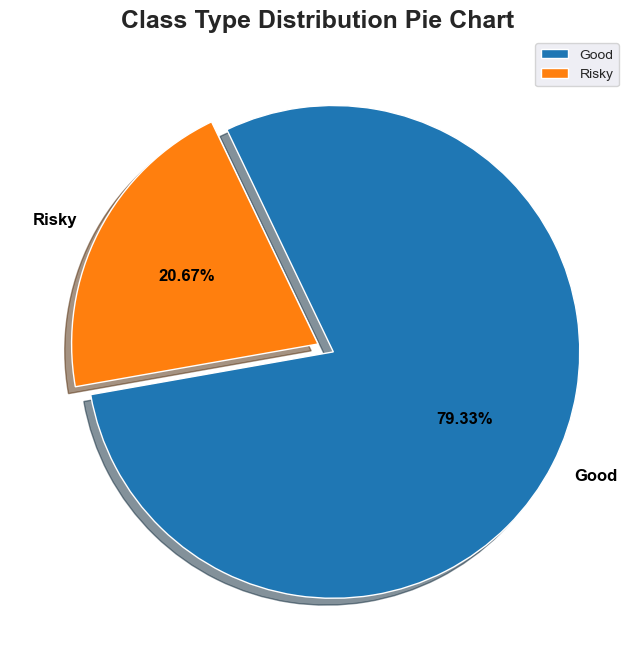

In [27]:
plt.figure(figsize = (12,8))
plt.pie(df1['taxable_category'].value_counts(),
       labels=df1.taxable_category.unique(),
       explode = [0.07,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'horizontal',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

##### data is imbalanced, the class “Good” is called the majority class, and the much smaller in size “Risky” class is called the minority class.

In [28]:
countNotermdeposit = len(df1[df1['taxable_category'] == 'Good'])
counthavetermdeposit = len(df1[df1['taxable_category'] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / (len(df1.taxable_category))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / (len(df1.taxable_category))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [29]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

Text(0.5, 1.0, 'Risky or Good for Individual Taxable Income ')

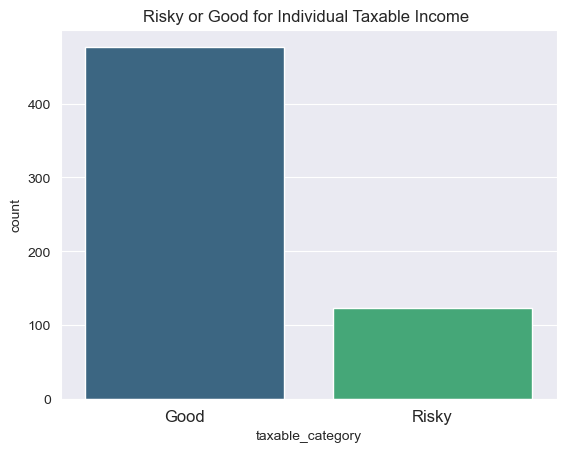

In [30]:
sns.countplot(x='taxable_category', data=df1, palette = 'viridis', 
              order=df1['taxable_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')

## Feature Selection Technique

###  Data Pre-Processing

In [31]:
model_data = df1.copy()
model_data.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','Work.Experience':'Work_Experience','City.Population':'City_Population'}, inplace = True)
model_data.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = model_data.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'taxable_category'], dtype='object')

In [32]:
#Creating dummy vairables of the categorical features
le = LabelEncoder()
for col in categorical_features:
        le.fit(model_data[col])
        model_data[col] = le.transform(model_data[col])
model_data.head()

Undergrad  Marital_Status  City_Population  Work_Experience  Urban  \
0          0               2            50047               10      1   
1          1               0           134075               18      1   
2          0               1           160205               30      1   
3          1               2           193264               15      1   
4          0               1            27533               28      0   

   taxable_category  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

### Data Pre-processing for feature Selection

In [33]:
data_ = df1.copy()
data_.drop('Taxable.Income',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

City.Population  Work.Experience  Undergrad_NO  Undergrad_YES  \
0            50047               10             1              0   
1           134075               18             0              1   
2           160205               30             1              0   
3           193264               15             0              1   
4            27533               28             1              0   

   Marital.Status_Divorced  Marital.Status_Married  Marital.Status_Single  \
0                        0                       0                      1   
1                        1                       0                      0   
2                        0                       1                      0   
3                        0                       0                      1   
4                        0                       1                      0   

   Urban_NO  Urban_YES  
0         0          1  
1         0          1  
2         0          1  
3         0          1  
4         1          0

In [34]:
data_['Taxable_Income'] = df1.taxable_category
data_.head()

City.Population  Work.Experience  Undergrad_NO  Undergrad_YES  \
0            50047               10             1              0   
1           134075               18             0              1   
2           160205               30             1              0   
3           193264               15             0              1   
4            27533               28             1              0   

   Marital.Status_Divorced  Marital.Status_Married  Marital.Status_Single  \
0                        0                       0                      1   
1                        1                       0                      0   
2                        0                       1                      0   
3                        0                       0                      1   
4                        0                       1                      0   

   Urban_NO  Urban_YES Taxable_Income  
0         0          1           Good  
1         0          1           Good  
2         0          1           Good  
3         0          1           Good  
4         1          0           Good

In [35]:
le = LabelEncoder()
le.fit(data_["Taxable_Income"])
data_["Taxable_Income"]=le.transform(data_["Taxable_Income"])
data_.head()

City.Population  Work.Experience  Undergrad_NO  Undergrad_YES  \
0            50047               10             1              0   
1           134075               18             0              1   
2           160205               30             1              0   
3           193264               15             0              1   
4            27533               28             1              0   

   Marital.Status_Divorced  Marital.Status_Married  Marital.Status_Single  \
0                        0                       0                      1   
1                        1                       0                      0   
2                        0                       1                      0   
3                        0                       0                      1   
4                        0                       1                      0   

   Urban_NO  Urban_YES  Taxable_Income  
0         0          1               0  
1         0          1               0  
2         0          1               0  
3         0          1               0  
4         1          0               0

###  Test Train Split With Imbalanced Dataset

In [38]:
model_data.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'taxable_category'],
      dtype='object')

In [39]:
x = model_data.drop('taxable_category',axis=1)
y = model_data['taxable_category']

In [40]:
y.unique()

array([0, 1])

In [41]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({0: 429, 1: 111}) Testing Data Counter({0: 47, 1: 13})


In [42]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [43]:
# summarize train and test composition
counter_train = Counter(y_train)
counter_test = Counter(y_test)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({0: 333, 1: 87}) Testing Data Counter({0: 143, 1: 37})


In [44]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


###  Grid search using Stratified Kfold Splits on Imbalanced Dataset

In [45]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(train_X, train_y)

print_score(rf_clf, train_X, train_y, test_X, test_y, train=True)
print_score(rf_clf, train_X, train_y, test_X, test_y, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    429.0  111.0       1.0      540.0         540.0
_______________________________________________
Confusion Matrix: 
 [[429   0]
 [  0 111]]

Test Result:
Accuracy Score: 75.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.785714   0.250000      0.75   0.517857      0.669643
recall      0.936170   0.076923      0.75   0.506547      0.750000
f1-score    0.854369   0.117647      0.75   0.486008      0.694746
support    47.000000  13.000000      0.75  60.000000     60.000000
_______________________________________________
Confusion Matr

### 6.2 Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset<a class="anchor" id="6.2"></a> 

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1  accuracy  macro avg  weighted avg
precision    1.0   1.0       1.0        1.0           1.0
recall       1.0   1.0       1.0        1.0           1.0
f1-score     1.0   1.0       1.0        1.0           1.0
support    333.0  87.0       1.0      420.0         420.0
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [  0  87]]

Test Result:
Accuracy Score: 75.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.784884   0.0      0.75    0.392442      0.623547
recall       0.944056   0.0      0.75    0.472028      0.750000
f1-score     0.857143   0.0      0.75    0.428571      0.680952
support    143.000000  37.0      0.75  180.000000    180.000000
_______________________________________________
Confusion Matrix: 
 [[135   8]
 [ 

#### Observation: 
+ In both the condition, due to imbalanced dataset our results are getting biased towards the majority. The model is correctly classifying all the majority classes yet fails to classify the minority classes. Hence, we need to use some kind of oversampling techniques to balance the dataset.

##  Random Forest


###  Random Forest hyperparameter tuning


In [48]:
#base model
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [49]:
loc = np.array(score_array).max()
score_array.index(loc)+1

176

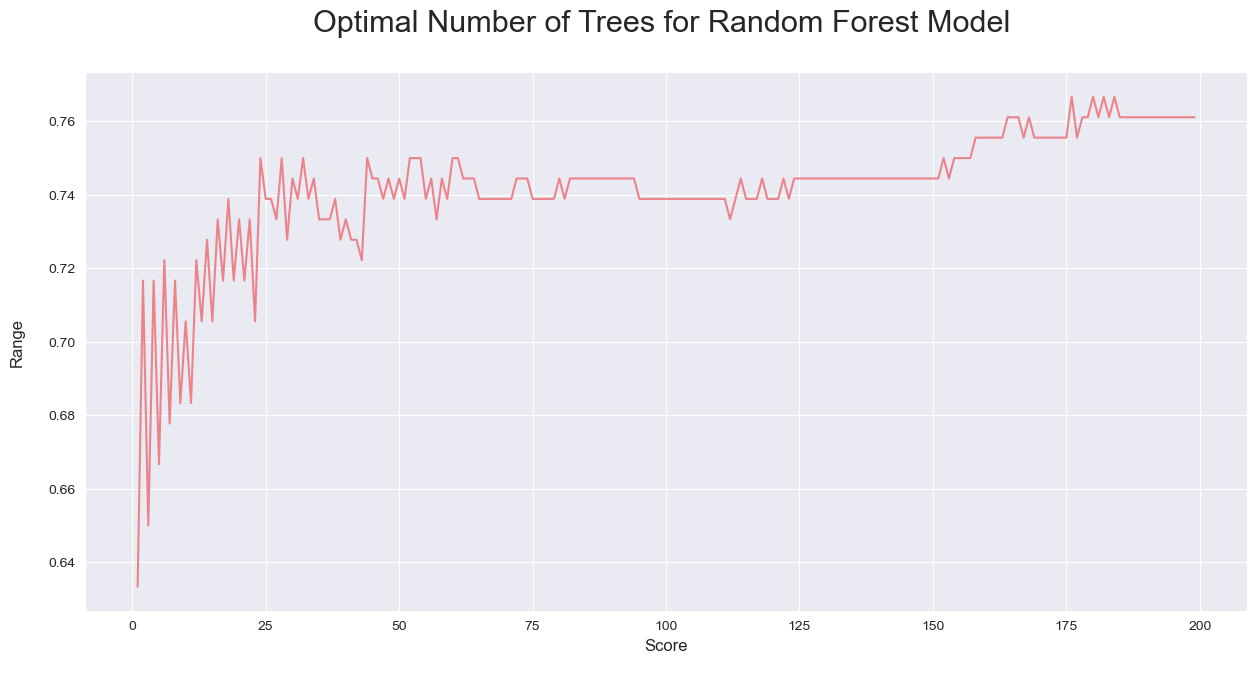

In [50]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

#### a) Randomized Search Cross Validation<a class="anchor" id="a"></a> 

In [51]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 1, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True})
Train Result:
Accuracy Score: 71.43%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.825688   0.322581  0.714286    0.574134      0.721473
recall       0.810811   0.344828  0.714286    0.577819      0.714286
f1-score     0.818182   0.333333  0.714286    0.575758      0.717749
support    333.000000  87.000000  0.714286  420.000000    420.000000
_______________________________________________
Confusion Matrix: 
 [[270  63]
 [ 57  30]]

Test Result:
Accuracy Score: 65.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.794118   0.204545      0.65    0.499332      0.672928


#### `Random search` allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with `GridSearchCV`, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define

#### b) Grid Search Cross Validation<a class="anchor" id="b"></a> 

In [52]:
# Create a pipeline with a Random forest classifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from time import time
    
pipe_rfc = Pipeline([ 
                      ('scl', StandardScaler()), 
                    ('rfc', RandomForestClassifier(random_state=0, n_jobs=-1) )])

# Set the grid parameters
param_grid_rfc =  [ {
    'rfc__n_estimators': [100, 200,300,400], # number of estimators
    #'rfc__criterion': ['gini', 'entropy'],   # Splitting criterion
    'rfc__max_features':[0.05 , 0.1], # maximum features used at each split
    'rfc__max_depth': [None, 5], # Max depth of the trees
    'rfc__min_samples_split': [0.005, 0.01], # mininal samples in leafs
    }]
# Use 10 fold CV
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state= 0)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring='f1', verbose= 1, n_jobs=-1)

#Fit the pipeline
start = time()
grid_rfc = grid_rfc.fit(x_train, y_train)
end = time()

print("RFC grid search took %.3f seconds" %(end-start))

# Best score and best parameters
print('-------Best score----------')
print(grid_rfc.best_score_ * 100.0)
print('-------Best params----------')
print(grid_rfc.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
RFC grid search took 88.412 seconds
-------Best score----------
1.8181818181818181
-------Best params----------
{'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.01, 'rfc__n_estimators': 100}


### 8.2 Visualizing one of the decision tree in random forest<a class="anchor" id="8.2"></a> 

In [53]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10, n_estimators=1,
                       random_state=42)

In [54]:
df1.taxable_category.unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

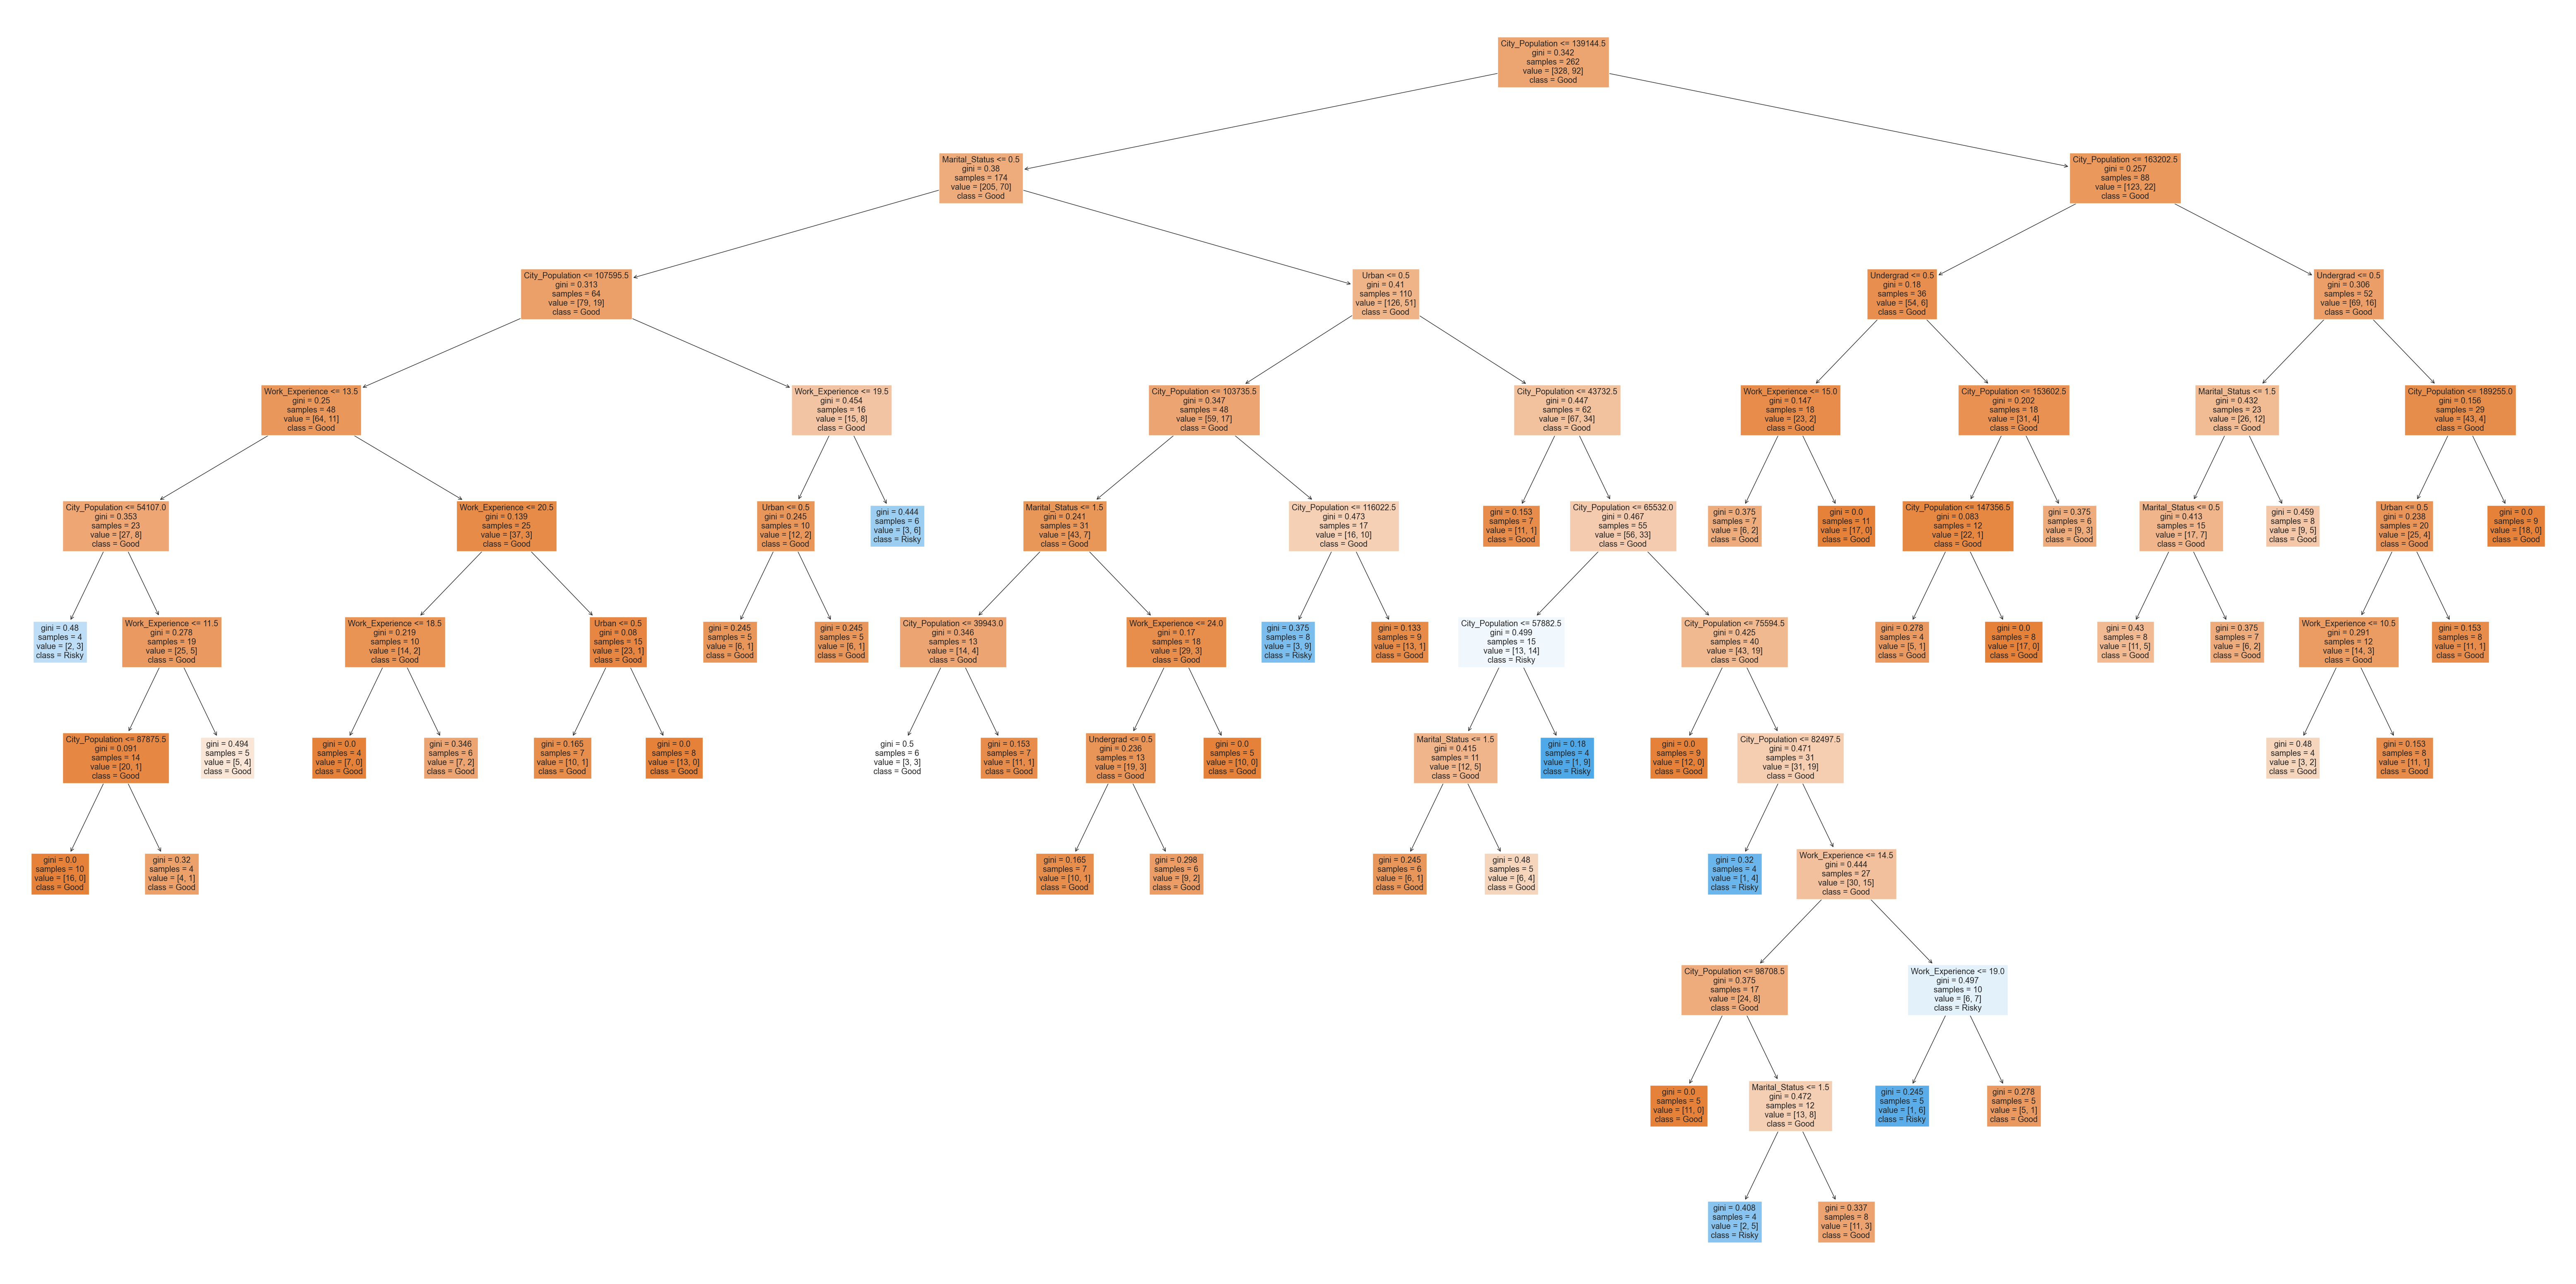

In [60]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[0], feature_names = model_data.columns,class_names=df1.taxable_category.unique(),filled=True)
plt.show()

### Advantages of Random Forest
 ####  It can be used in classification and regression problems.

 ####  It solves the problem of overfitting as output is based on majority voting or averaging.

 ####  It performs well even if the data contains null/missing values.

 ####  Each decision tree created is independent of the other thus it shows the property of parallelization.

 ####  It maintains diversity as all the attributes are not considered while making each decision tree though it is not true in all cases.

 #### It is immune to the curse of dimensionality. Since each tree does not consider all the attributes, feature space is reduced.